In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

import math

## Description

Prediction with neural nets simple MLP for emotion classifications from gradients "to specify what we extract exactly"
OR 
predict intensity values group level during specific movie
GOAL: Predict class of emotions from extracted features of group level gradients 

## Table of Contents
- [Predictive within Same Movie]()
    - [Features Preparation](#feature)
    - [NN Model](#nn)
    - [Train and Prediction](#tpred)
    
- [Predictive train Movie and other pred movie]()

- [Predictive with groups of movies]()
- [(for fun) Apply group of movies trained model to group rest]()

## Predictive within Same Movie

<a class="anchor" id="feature"></a>
### Feature Preparation

In [2]:
networks = list(index2region.keys())

select   = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

In [3]:
# extract from emoBIDS intensity values ?
emo_df = pd.read_csv('./data/emotion_compileBIDS.csv')

In [4]:
moviename = "Chatter"

eg    = 'W_{}13.csv'.format(moviename)
eg_df = emo_df[emo_df.filename == eg]

emo_array = []
for emo in eg_df.item.unique():
    if emo in select:
        emo_array.append(np.array(eg_df[eg_df.item == emo].score))

emo_array = np.asarray(emo_array)

# Remove reduncdant emotions, meaning colinear vectors
colinear = (np.abs(FC(emo_array.T)) - np.eye(13)) > 0.80 # arbitrary thresh
keep = []
for i in range(len(colinear)):
    redundant = np.where(colinear[i])[0]
    if np.sum([r in keep for r in redundant]) == 0:
        keep.append(i)
    else:
        print(i)
keep       = np.array(keep)
decolinear = emo_array[keep]

7
8


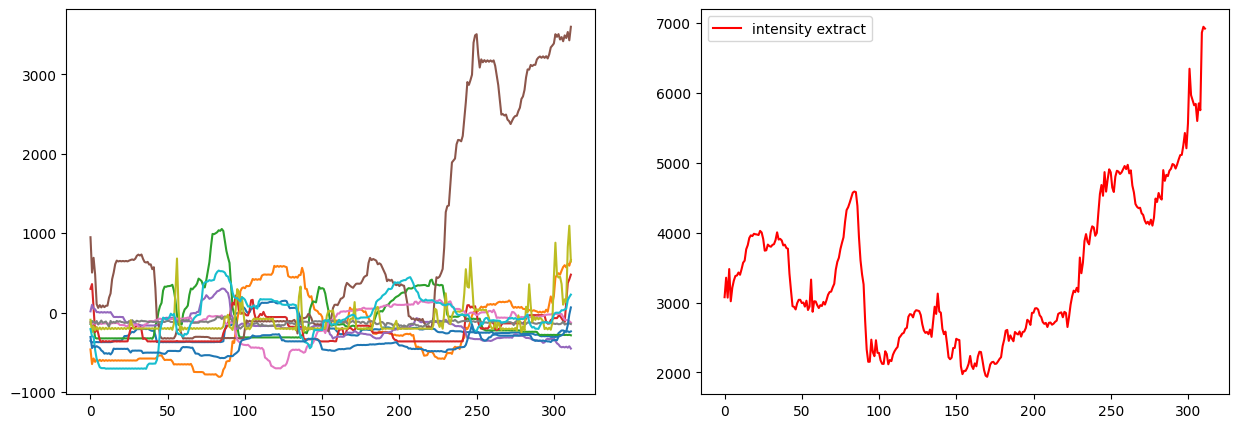

In [5]:
# selected gradients moments?
# predict moments of gradients 
intensity = np.abs(decolinear).sum(axis=0)

fig, ax   = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(decolinear.T)
ax[1].plot(intensity, c='r', label='intensity extract')
ax[1].legend()
plt.show()

(312,)

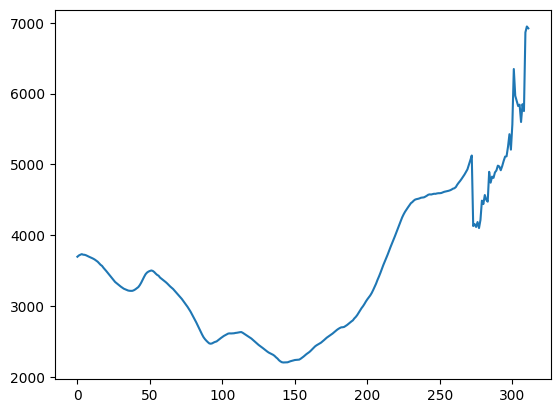

In [7]:
ws = 40
featureY = overlap_add(intensity, wsize=ws, pad=True)
plt.plot(featureY)
featureY.shape

In [8]:
# load dynamic gradients
featureX = load('./resources/dynamic_grad/group_level/{}_40_grad.pkl'.format(moviename))[0][:,:,:3]
# featureX = featureX.reshape(len(featureX), -1)


# if feature extracted the regions concentration
A = np.zeros((featureX.shape[0], len(networks)))
for p in range(featureX.shape[0]):
    for nidx, n in enumerate(networks):
        A[p,nidx] = network_volume(featureX[p], n)
featureX = deepcopy(A)


# same sizing
L = min(len(featureX), len(featureY))
featureX = featureX[:L]
featureY = featureY[:L]

Spare test set

In [245]:
np.random.seed(10)
# test_idx    = np.random.choice(np.arange(len(featureX)), 22, replace=False)
test_idx    = np.arange(200,400)
val_idx     = np.arange(500,600)
working_idx = np.array(list(set(np.arange(len(featureX))) - set(test_idx) - set(val_idx)))
X      = featureX[working_idx]
y      = featureY[working_idx]

x_valid = featureX[val_idx]
y_valid = featureY[val_idx]

x_test = featureX[test_idx]
y_test = featureY[test_idx]

### NN Model

In [246]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split


In [247]:
# x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=93)

In [248]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [249]:
device

device(type='cpu')

In [250]:
x_train = torch.tensor(x_train).to(device).type(torch.FloatTensor)
x_valid = torch.tensor(x_valid).to(device).type(torch.FloatTensor)
y_train = torch.tensor(y_train).to(device).type(torch.FloatTensor)
y_valid = torch.tensor(y_valid).to(device).type(torch.FloatTensor)
x_test  = torch.tensor(x_test).to(device).type(torch.FloatTensor)
y_test  = torch.tensor(y_test).to(device).type(torch.FloatTensor)

In [251]:
x_train.dtype

torch.float32

NOTE USEFUL: sklearn.utils.shuffle

In [252]:
import torch.nn.functional as F
import torch.optim as optim


class MLP(nn.Module):
    def __init__(self, idim):
        super().__init__()
        self.fc1 = nn.Linear(idim, 120)
        self.fc2 = nn.Linear(120,32)
        self.fc3 = nn.Linear(32,1)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = x.squeeze(1)

        return x

### Train and Validation

In [253]:
nb_epoch   = 15000
batch_size = 100

In [254]:
np.random.seed(93)
mlp     = MLP(7).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(mlp.parameters(),  lr=1e-7)
# optimizer = optim.Adam(mlp.parameters(),  lr=1e-4)

logs = {'train': [], 'validation': []}

size = x_train.shape[0]
for epoch in range(nb_epoch):
    
    for i in range(math.ceil(size/batch_size)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = x_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlp(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # print statistics for train and validation set
    with torch.no_grad():
        # train
        train_pred = mlp(x_train)
        train_loss = loss_fn(train_pred, y_train)
        
        # validation 
        val_pred = mlp(x_valid)
        val_loss = loss_fn(val_pred, y_valid)
        
        test_pred = mlp(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        if epoch % 100 == 0:
            print("##################")
            print("Epoch {} MSE loss per sample is {} (Train)".format(epoch, train_loss))
            print("Epoch {} MSE loss per sample is {} (Validation)\n".format(epoch, val_loss))
            print("Epoch {} MSE loss per sample is {} (Test)\n".format(epoch, test_loss))            
        
        logs['train'].append(train_loss)
        logs['validation'].append(val_loss)

##################
Epoch 0 MSE loss per sample is 9634196.0 (Train)
Epoch 0 MSE loss per sample is 20977382.0 (Validation)

Epoch 0 MSE loss per sample is 9110611.0 (Test)

##################
Epoch 100 MSE loss per sample is 1081608.0 (Train)
Epoch 100 MSE loss per sample is 3367252.75 (Validation)

Epoch 100 MSE loss per sample is 452519.4375 (Test)

##################
Epoch 200 MSE loss per sample is 805010.5625 (Train)
Epoch 200 MSE loss per sample is 3760819.25 (Validation)

Epoch 200 MSE loss per sample is 447847.59375 (Test)

##################
Epoch 300 MSE loss per sample is 577366.5625 (Train)
Epoch 300 MSE loss per sample is 4327709.5 (Validation)

Epoch 300 MSE loss per sample is 483438.8125 (Test)

##################
Epoch 400 MSE loss per sample is 483929.9375 (Train)
Epoch 400 MSE loss per sample is 4553397.0 (Validation)

Epoch 400 MSE loss per sample is 495017.3125 (Test)

##################
Epoch 500 MSE loss per sample is 451002.5 (Train)
Epoch 500 MSE loss per sample

##################
Epoch 4500 MSE loss per sample is 147064.8125 (Train)
Epoch 4500 MSE loss per sample is 6230773.0 (Validation)

Epoch 4500 MSE loss per sample is 485213.125 (Test)

##################
Epoch 4600 MSE loss per sample is 142654.3125 (Train)
Epoch 4600 MSE loss per sample is 6242651.5 (Validation)

Epoch 4600 MSE loss per sample is 487848.5625 (Test)

##################
Epoch 4700 MSE loss per sample is 141009.28125 (Train)
Epoch 4700 MSE loss per sample is 6343391.5 (Validation)

Epoch 4700 MSE loss per sample is 497592.75 (Test)

##################
Epoch 4800 MSE loss per sample is 141758.359375 (Train)
Epoch 4800 MSE loss per sample is 6426477.0 (Validation)

Epoch 4800 MSE loss per sample is 507068.59375 (Test)

##################
Epoch 4900 MSE loss per sample is 144098.15625 (Train)
Epoch 4900 MSE loss per sample is 6496442.0 (Validation)

Epoch 4900 MSE loss per sample is 517193.84375 (Test)

##################
Epoch 5000 MSE loss per sample is 138318.390625 (Trai

##################
Epoch 9000 MSE loss per sample is 63725.85546875 (Train)
Epoch 9000 MSE loss per sample is 5772946.0 (Validation)

Epoch 9000 MSE loss per sample is 1160397.0 (Test)

##################
Epoch 9100 MSE loss per sample is 62030.98828125 (Train)
Epoch 9100 MSE loss per sample is 5733013.0 (Validation)

Epoch 9100 MSE loss per sample is 1194880.25 (Test)

##################
Epoch 9200 MSE loss per sample is 74743.96875 (Train)
Epoch 9200 MSE loss per sample is 5998694.0 (Validation)

Epoch 9200 MSE loss per sample is 1123231.25 (Test)

##################
Epoch 9300 MSE loss per sample is 78677.8828125 (Train)
Epoch 9300 MSE loss per sample is 5112561.5 (Validation)

Epoch 9300 MSE loss per sample is 1541133.875 (Test)

##################
Epoch 9400 MSE loss per sample is 69015.0 (Train)
Epoch 9400 MSE loss per sample is 5920856.5 (Validation)

Epoch 9400 MSE loss per sample is 1193009.0 (Test)

##################
Epoch 9500 MSE loss per sample is 75670.984375 (Train)
Epo

##################
Epoch 13400 MSE loss per sample is 38165.71484375 (Train)
Epoch 13400 MSE loss per sample is 5453530.0 (Validation)

Epoch 13400 MSE loss per sample is 2124168.5 (Test)

##################
Epoch 13500 MSE loss per sample is 51672.93359375 (Train)
Epoch 13500 MSE loss per sample is 5726648.5 (Validation)

Epoch 13500 MSE loss per sample is 1936968.0 (Test)

##################
Epoch 13600 MSE loss per sample is 39320.80859375 (Train)
Epoch 13600 MSE loss per sample is 5491266.0 (Validation)

Epoch 13600 MSE loss per sample is 2106962.0 (Test)

##################
Epoch 13700 MSE loss per sample is 48118.34765625 (Train)
Epoch 13700 MSE loss per sample is 5680708.0 (Validation)

Epoch 13700 MSE loss per sample is 1980152.625 (Test)

##################
Epoch 13800 MSE loss per sample is 38632.34765625 (Train)
Epoch 13800 MSE loss per sample is 5455430.5 (Validation)

Epoch 13800 MSE loss per sample is 2165866.5 (Test)

##################
Epoch 13900 MSE loss per sample is

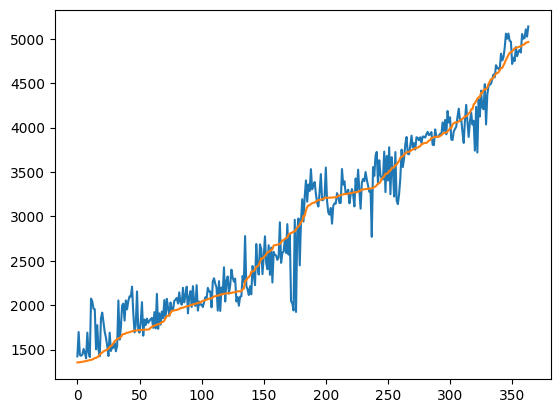

In [242]:
plt.plot(train_pred[np.argsort(y_train)])
plt.plot(y_train[np.argsort(y_train)])

In [243]:
plt.plot(val_pred[np.argsort(y_valid)])
plt.plot(y_valid[np.argsort(y_valid)])

IndexError: index 91 is out of bounds for dimension 0 with size 91

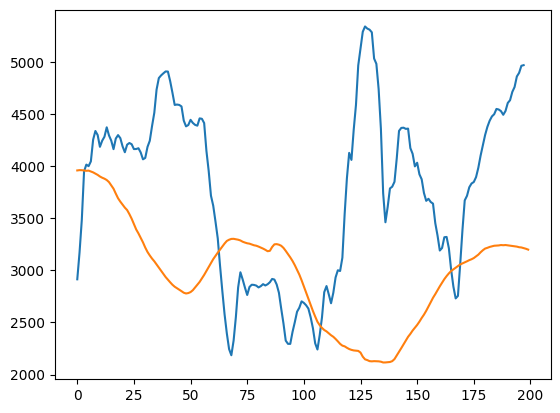

In [244]:
plt.plot(overlap_add(test_pred))
plt.plot(y_test)

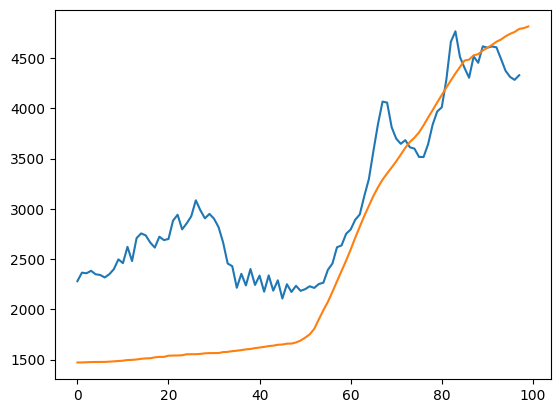

In [187]:
with torch.no_grad():
    test_pred = mlp(x_test)
    
plt.plot(overlap_add(test_pred[np.argsort(y_test)]))
plt.plot(y_test[np.argsort(y_test)])

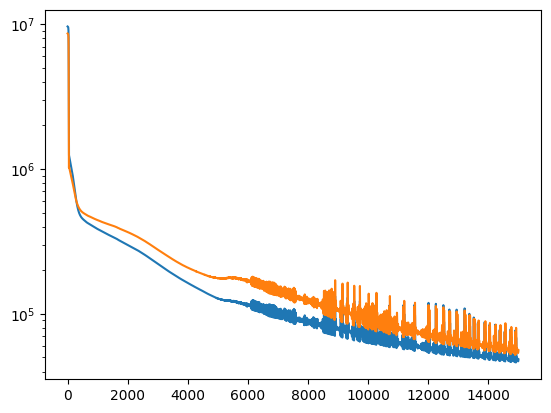

In [188]:
plt.plot(logs['train'])
plt.plot(logs['validation'])
plt.yscale('log')

## Predictive train Movie to other  Movie

In [189]:
eg    = 'W_Payload13.csv'
eg_df = emo_df[emo_df.filename == eg]

emo_array = []
for emo in eg_df.item.unique():
    if emo in select:
        emo_array.append(np.array(eg_df[eg_df.item == emo].score))

emo_array = np.asarray(emo_array)

# Remove reduncdant emotions, meaning colinear vectors
colinear = (np.abs(FC(emo_array.T)) - np.eye(13)) > 0.80 # arbitrary thresh
keep = []
for i in range(len(colinear)):
    redundant = np.where(colinear[i])[0]
    if np.sum([r in keep for r in redundant]) == 0:
        keep.append(i)
    else:
        print(i)
keep       = np.array(keep)
decolinear = emo_array[keep]

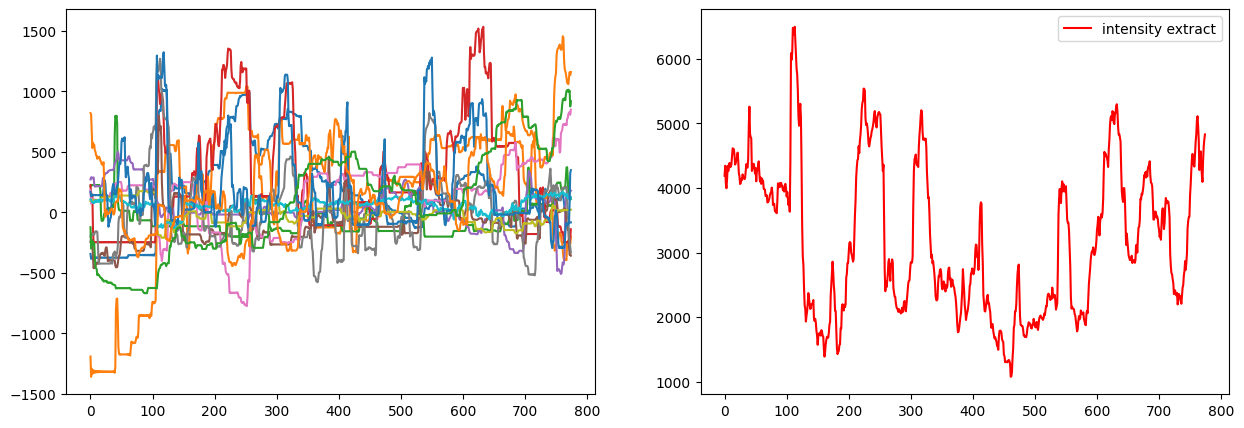

In [190]:
# selected gradients moments?
# predict moments of gradients 
intensity = np.abs(decolinear).sum(axis=0)

fig, ax   = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(decolinear.T)
ax[1].plot(intensity, c='r', label='intensity extract')
ax[1].legend()
plt.show()

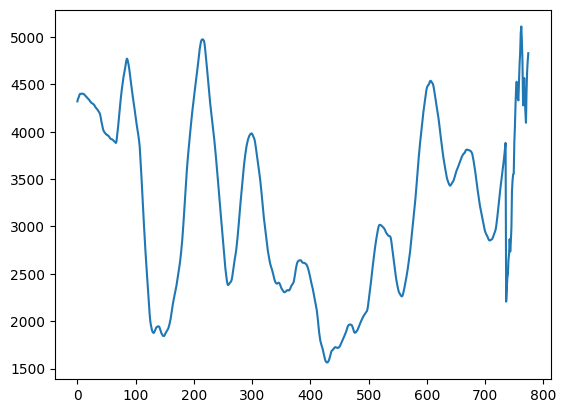

In [191]:
ws = 40
featureY = overlap_add(intensity, wsize=ws, pad=True)
plt.plot(featureY)

In [198]:
# load dynamic gradients
featureX = load('./resources/dynamic_grad/group_level/Payload_40_grad.pkl')[0][:,:,:3]
# featureX = featureX.reshape(len(featureX), -1)

# if feature extracted the regions concentration
A = np.zeros((featureX.shape[0], len(networks)))
for p in range(featureX.shape[0]):
    for nidx, n in enumerate(networks):
        A[p,nidx] = network_volume(featureX[p], n)
featureX = deepcopy(A)

# same sizing
L = min(len(featureX), len(featureY))
featureX = featureX[:L]
featureY = featureY[:L]

In [194]:
featureX = torch.tensor(featureX).to(device).type(torch.FloatTensor)
featureY = torch.tensor(featureY).to(device).type(torch.FloatTensor)

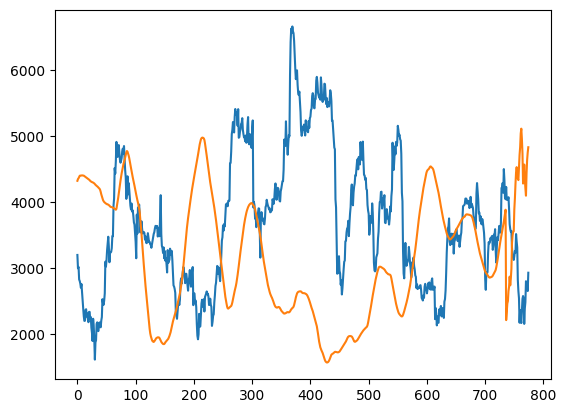

In [195]:
with torch.no_grad():
    other_pred = mlp(featureX)
plt.plot(other_pred)
plt.plot(featureY)

## Predictive with groups of movies

In [202]:
# all movies order
movie_order = emo_df.filename.unique()

In [203]:
fX, fY = [], []
for m in tqdm(movie_order):
    moviename = m[2:-6]
    eg_df = emo_df[emo_df.filename == m]

    emo_array = []
    for emo in eg_df.item.unique():
        if emo in select:
            emo_array.append(np.array(eg_df[eg_df.item == emo].score))

    emo_array = np.asarray(emo_array)

    # Remove reduncdant emotions, meaning colinear vectors
    colinear = (np.abs(FC(emo_array.T)) - np.eye(13)) > 0.80 # arbitrary thresh
    keep = []
    for i in range(len(colinear)):
        redundant = np.where(colinear[i])[0]
        if np.sum([r in keep for r in redundant]) == 0:
            keep.append(i)
    keep       = np.array(keep)
    decolinear = emo_array[keep]
    intensity = np.abs(decolinear).sum(axis=0)
    
    ws = 40
    featureY = overlap_add(intensity, wsize=ws, pad=False)
    if moviename == 'BetweenViewings':
        moviename = moviename[:-1]
    featureX = load('./resources/dynamic_grad/group_level/{}_40_grad.pkl'.format(moviename))[0][:,:,:3]

    A = np.zeros((featureX.shape[0], len(networks)))
    for p in range(featureX.shape[0]):
        for nidx, n in enumerate(networks):
            A[p,nidx] = network_volume(featureX[p], n)
    featureX = deepcopy(A)
    
    L = min(len(featureX), len(featureY))
    featureX = featureX[:L]
    featureY = featureY[:L]
    
    fX.append(featureX)
    fY.append(featureY)

fX = np.concatenate(fX)
fY = np.concatenate(fY)

100%|████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.26s/it]


In [208]:
fX.shape

(6839, 7)

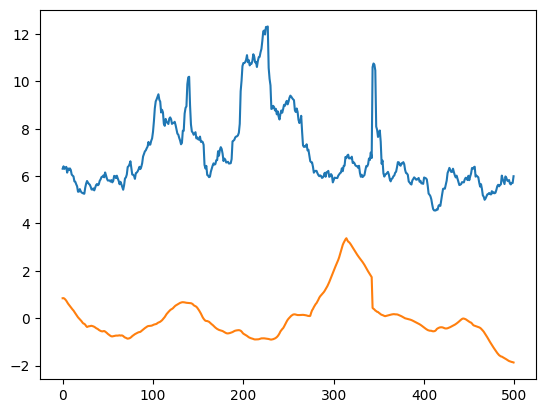

In [219]:
plt.plot(fX[:500,6])
plt.plot(zscore(fY[:500]))

In [143]:
fY = zscore(fY)

In [490]:
# aligned, ref, score = procrustes_align(list(fX))
# fX = np.asarray(aligned)

Spare Test Set

In [145]:
np.random.seed(10)

test_idx    = np.arange(5000, 6839)
working_idx = np.array(list(set(np.arange(len(fX))) - set(test_idx)))
X      = fX[working_idx]
y      = fY[working_idx]

x_test = fX[test_idx]
y_test = fY[test_idx]

In [146]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=93)

In [147]:
x_train = torch.tensor(x_train).to(device).type(torch.FloatTensor)
x_valid = torch.tensor(x_valid).to(device).type(torch.FloatTensor)
y_train = torch.tensor(y_train).to(device).type(torch.FloatTensor)
y_valid = torch.tensor(y_valid).to(device).type(torch.FloatTensor)
x_test  = torch.tensor(x_test).to(device).type(torch.FloatTensor)
y_test  = torch.tensor(y_test).to(device).type(torch.FloatTensor)

In [153]:
import torch.nn.functional as F
import torch.optim as optim


class MLP(nn.Module):
    def __init__(self, idim):
        super().__init__()
        self.fc1 = nn.Linear(idim, 120)
        self.fc2 = nn.Linear(120,32)
#         self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,1)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        x = x.squeeze(1)

        return x

In [156]:
nb_epoch   = 1000
batch_size = 100

In [157]:
np.random.seed(93)
mlp     = MLP(7).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(mlp.parameters(),  lr=1e-4)
# optimizer = optim.Adam(mlp.parameters(),  lr=1e-5)

logs = {'train': [], 'validation': []}

size = x_train.shape[0]
for epoch in range(nb_epoch):
    
    for i in range(math.ceil(size/batch_size)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = x_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlp(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # print statistics for train and validation set
    with torch.no_grad():
        # train
        train_pred = mlp(x_train)
        train_loss = loss_fn(train_pred, y_train)
        
        # validation 
        val_pred = mlp(x_valid)
        val_loss = loss_fn(val_pred, y_valid)
        
        test_pred = mlp(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        if epoch % 10 == 0:
            print("##################")
            print("Epoch {} MSE loss per sample is {} (Train)".format(epoch, train_loss))
            print("Epoch {} MSE loss per sample is {} (Validation)\n".format(epoch, val_loss))
            print("Epoch {} MSE loss per sample is {} (Test)\n".format(epoch, test_loss))            
        
        logs['train'].append(train_loss)
        logs['validation'].append(val_loss)

##################
Epoch 0 MSE loss per sample is 1.0625977516174316 (Train)
Epoch 0 MSE loss per sample is 1.0472780466079712 (Validation)

Epoch 0 MSE loss per sample is 1.1369158029556274 (Test)

##################
Epoch 10 MSE loss per sample is 1.0279121398925781 (Train)
Epoch 10 MSE loss per sample is 1.0246306657791138 (Validation)

Epoch 10 MSE loss per sample is 1.0720930099487305 (Test)

##################
Epoch 20 MSE loss per sample is 1.0120400190353394 (Train)
Epoch 20 MSE loss per sample is 1.0148996114730835 (Validation)

Epoch 20 MSE loss per sample is 1.0488380193710327 (Test)

##################
Epoch 30 MSE loss per sample is 1.00099515914917 (Train)
Epoch 30 MSE loss per sample is 1.0071154832839966 (Validation)

Epoch 30 MSE loss per sample is 1.0350208282470703 (Test)

##################
Epoch 40 MSE loss per sample is 0.9918553233146667 (Train)
Epoch 40 MSE loss per sample is 1.0007610321044922 (Validation)

Epoch 40 MSE loss per sample is 1.02559494972229 (Test

##################
Epoch 410 MSE loss per sample is 0.9112979769706726 (Train)
Epoch 410 MSE loss per sample is 0.9495171308517456 (Validation)

Epoch 410 MSE loss per sample is 1.0041263103485107 (Test)

##################
Epoch 420 MSE loss per sample is 0.9102122783660889 (Train)
Epoch 420 MSE loss per sample is 0.948662519454956 (Validation)

Epoch 420 MSE loss per sample is 1.0049824714660645 (Test)

##################
Epoch 430 MSE loss per sample is 0.9091269969940186 (Train)
Epoch 430 MSE loss per sample is 0.9478116035461426 (Validation)

Epoch 430 MSE loss per sample is 1.0056930780410767 (Test)

##################
Epoch 440 MSE loss per sample is 0.908046543598175 (Train)
Epoch 440 MSE loss per sample is 0.9469488859176636 (Validation)

Epoch 440 MSE loss per sample is 1.0065531730651855 (Test)

##################
Epoch 450 MSE loss per sample is 0.9069569706916809 (Train)
Epoch 450 MSE loss per sample is 0.9460382461547852 (Validation)

Epoch 450 MSE loss per sample is 1.00

##################
Epoch 820 MSE loss per sample is 0.8680651783943176 (Train)
Epoch 820 MSE loss per sample is 0.9168767929077148 (Validation)

Epoch 820 MSE loss per sample is 1.0390629768371582 (Test)

##################
Epoch 830 MSE loss per sample is 0.8671008944511414 (Train)
Epoch 830 MSE loss per sample is 0.9161769151687622 (Validation)

Epoch 830 MSE loss per sample is 1.039872407913208 (Test)

##################
Epoch 840 MSE loss per sample is 0.8661417961120605 (Train)
Epoch 840 MSE loss per sample is 0.9154791235923767 (Validation)

Epoch 840 MSE loss per sample is 1.0404784679412842 (Test)

##################
Epoch 850 MSE loss per sample is 0.865182101726532 (Train)
Epoch 850 MSE loss per sample is 0.9147756099700928 (Validation)

Epoch 850 MSE loss per sample is 1.041166067123413 (Test)

##################
Epoch 860 MSE loss per sample is 0.8642306327819824 (Train)
Epoch 860 MSE loss per sample is 0.9140834808349609 (Validation)

Epoch 860 MSE loss per sample is 1.041

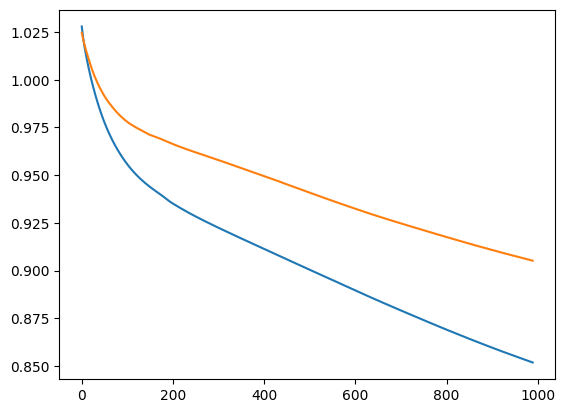

In [158]:
plt.plot(logs['train'][10:])
plt.plot(logs['validation'][10:])

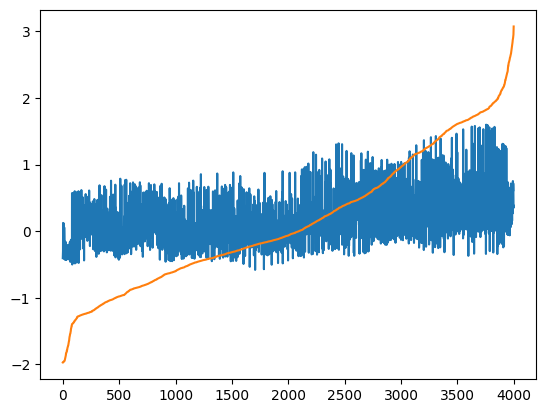

In [159]:
plt.plot(train_pred[np.argsort(y_train)])
plt.plot(y_train[np.argsort(y_train)])

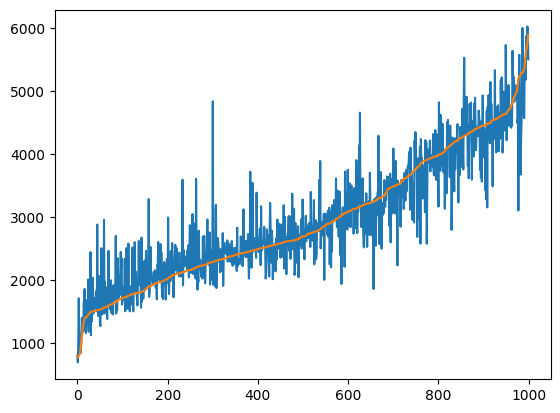

In [132]:
plt.plot(val_pred[np.argsort(y_valid)])
plt.plot(y_valid[np.argsort(y_valid)])

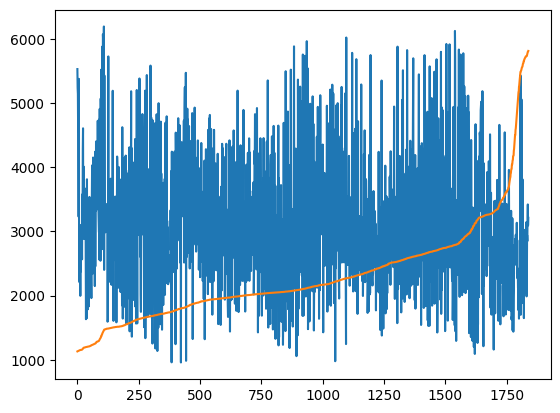

In [133]:
with torch.no_grad():
    test_pred = mlp(x_test)
    
plt.plot(test_pred[np.argsort(y_test)])
plt.plot(y_test[np.argsort(y_test)])
# pearson_correlation(test_pred, y_test[50:-50])

## (for fun) Apply group of movies trained model to group rest

In [ ]:
# load dynamic gradients
restX = load('./resources/dynamic_grad/group_level/Rest_40_grad.pkl')[0][:,:,:3]
# featureX = featureX.reshape(len(featureX), -1)

In [ ]:
with torch.no_grad():
    test_pred = mlp(restX)
    
plt.plot(test_pred)

Observe the weights as well

In [479]:
(mlp.fc1.weight.T.matmul(mlp.fc3.weight.T)).detach()

tensor([[ 2.5534e+01],
        [-9.3460e+00],
        [-1.2357e+01],
        ...,
        [ 2.3002e-02],
        [-4.1426e+00],
        [-3.5280e-01]])